# Trabajo Práctico 2: Críticas cinematográficas

<hr width="50%" align="left"/>

<br/>

## **Grupo:** 03 - **_"Hackers Panas"_**

<br/>

## **Integrantes:**

<p>
<img align="left" src="https://github.com/NLGS2907.png" height=50 width=50 />

### [Franco Lighterman Reismann](https://github.com/NLGS2907) (106714)
<br/>
</p>

<p>
<img align="left" src="https://github.com/MarcosGN.png" height=50 width=50 />

### [Marcos García Neira](https://github.com/MarcosGN) (110363)
<br/>
</p>

<p>
<img align="left" src="https://github.com/mmaddalena.png" height=50 width=50 />

### [Martín Andrés Madalena](https://github.com/mmaddalena) (107610)
</p>

<br/><br/><br/><br/>
<hr/>

# ***Imports* y otras librerías**

Importamos en un sólo lugar todas las librerías que vamos a utilizar:

In [1]:
# No queremos ver la salida de pip
%%capture
# ---------- #

%pip install keras==2.12.0
%pip install tensorflow==2.12.0
%pip install --no-deps scikeras==0.12.0

In [2]:
# Procesamiento de datos
import numpy as np
import pandas as pd

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Tensorflow / Keras
import tensorflow as tf
from scikeras.wrappers import KerasClassifier

# Sci-Kit Learn
from sklearn.exceptions import NotFittedError
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import (precision_score, recall_score, accuracy_score, f1_score, make_scorer,
                             confusion_matrix, classification_report)
from sklearn.model_selection import (train_test_split, KFold, StratifiedKFold, RandomizedSearchCV,
                                     GridSearchCV)
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

# Otras librerías de Machine-Learning
from xgboost import XGBClassifier

# type hinting
from typing import TYPE_CHECKING, Any, Literal, Optional, Union
if TYPE_CHECKING:
    from os import PathLike

# Otros
from IPython.display import display # preferible a print()
from pathlib import Path
from warnings import simplefilter
from google.colab import drive

simplefilter(action="ignore", category=FutureWarning)
simplefilter(action="ignore", category=UserWarning)

In [3]:
# Va en una celda aparte para que no trate de montarlo cada vez que hay incluir nuevas librerías
drive.mount("/content/drive")

Mounted at /content/drive


<hr/>

# **Preprocesamiento**

## **Importando los datasets**

In [4]:
# train = pd.read_csv("./Datasets/train.csv")
# test = pd.read_csv("./Datasets/test.csv")
train = pd.read_csv("https://raw.githubusercontent.com/NLGS2907/7506R-2C2023-GRUPO03/master/TPs/TP2/Datasets/train.csv")
test = pd.read_csv("https://raw.githubusercontent.com/NLGS2907/7506R-2C2023-GRUPO03/master/TPs/TP2/Datasets/test.csv")

In [5]:
# variables globales
columna_target = "sentimiento"

In [6]:
# train
display(train.head())
display(train.shape)

# test
display(test.head())
display(test.shape)

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo


(50000, 3)

,ID,review_es
0,60000,La mayor virtud de esta película es su existen...
1,60001,"No soy un experto cinéfilo, pero pocas veces m..."
2,60002,Si no eres un incondicional del humor estilo T...
3,60003,"No sé qué está pasando, si la gente se deja ll..."
4,60004,"Pero cuando amanece,y me quedo solo,siento en ..."


(8599, 2)

<hr/>

# **Funciones Auxiliares**

Creamos una función auxiliar para vectorizar los textos de las reseñas:

In [7]:
def vectorizar_palabras(df: pd.DataFrame,
                        *,
                        vectorizador: Union[CountVectorizer, TfidfVectorizer, None]=None,
                        target_col: Optional[str]=None,
                        data_col: str="review_es",
                        prefix_cols: tuple[str, ...]=("ID",),
                        min_df: Union[int, float]=1,
                        max_df: Union[int, float]=1.0,
                        max_features: Optional[int]=None
    ) -> pd.DataFrame:
    """
    Transforma una DataFrame de pandas utilizando el algoritmo 'bag of words'.
    -
    'vectorizador': El objeto que vectoriza los datos. Puede o no estar ya fitteado.

    'target_col': El nombre de la columna objetivo. Puede o no estar presente.

    'data_col': El nombre de la columna con los textos a analizar.

    'prefix_cols': Nombres de oclumnas que deberían agregarse antes de todas las columnas
                   vectorizadas.

    'min_df/max_df': Los porcentajes (o cuentas) de las características máximas a tener en
                     cuenta al vectorizar las palabras. Por ejemplo, es útil si sólo se
                     quiere tomar en cuenta las que aparecen en el 10% de los documentos.

    'max_features': La cantidad de columnas máximas a tener en cuenta. Si no es `None`, se
                    tendrán en cuenta las N más frecuentes.
    """

    if vectorizador is None:
        vectorizador = TfidfVectorizer(min_df=min_df, max_df=max_df, max_features=max_features)

    try:
        bag = vectorizador.transform(df[data_col])

    except NotFittedError:
        bag = vectorizador.fit_transform(df[data_col])


    df_bag = pd.DataFrame.sparse.from_spmatrix(bag,
                                               columns=[f"c_{feat}" for feat
                                                        in vectorizador.vocabulary_.keys()])
    return pd.concat((
            df[list(prefix_cols)],
            df_bag,
            df[[target_col] if target_col is not None else []]
        ),
        axis="columns"
    )

Otra para separar los ejes entre los datos de entrenamiento y el *target*:

In [8]:
def split_in_axes(df: pd.DataFrame,
                  *,
                  x_innecesarias: tuple[str, ...]=("ID", "sentimiento"),
                  target: Optional[str]=None
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Devuelve los ejes a entrenar/testear de un DataFrame.
    -
    'x_innecesarias': Qué columnas no incluir en el split del eje X.

    'target': La variable objetivo que terminará en el split del eje Y.
              El target también es eliminado, si se puede, del split del eje X.
    """

    if target is not None and target not in x_innecesarias:
        x_innecesarias = tuple(list(x_innecesarias).append(target))

    df_x = df.copy()
    for indeseada in x_innecesarias:
        if indeseada in df.columns:
            df_x = df_x.drop(indeseada, axis="columns", inplace=False)

    df_y = (None if target is None else df[target].copy())

    return df_x, df_y

Otra para buscar por _Cross Validation_:

In [9]:
def buscar_por_cv(*,
                  metodo: Literal["random", "grid"]="grid",
                  clasificador,
                  params_cv: dict[str, Any],
                  puntaje: Literal["accuracy", "recall", "precision", "f1"]="f1",

                  rand_comb: int=10,
                  folds: int=10,
                  kfold_estratificado: bool=True,
                  seed: Optional[int]=None) -> Union[RandomizedSearchCV, GridSearchCV]:
    """
    Realiza cross validation con parámetros dados.
    -
    'metodo': Con qué metodo realizar el trabajo:
              - 'random' es para utilizar `sklearn.model_selection.RandomizedSearchCV`
              - 'grid' es para utilizar `sklearn.model_selection.GridSearchCV`

    'clasificador': Un objeto estimador, ya inicializado: un árbol de decisión,
                    un clasificador KNN, etc.

    'params_cv': El diccionario de parámetros a probar en cada intento. Se asume que son compatibles
                 con el clasificador pasado.

    'puntaje': Método de puntaje:
               - 'accuracy' utiliza el Accuracy Score.
               - 'recall' utiliza el Recall Score.
               - 'precision' utiliza el Precision Score.
               - 'f1' utiliza el F1-Score.

    'rand_comb': Cantidad de combinaciones a probar si se elige el método 'random'.

    'folds': Cantidad de folds a usar en el KFold.

    'kfold_estratificado': Si utilizar `sklearn.model_selection.StratifiedKFold` o
                           `sklearn.model_selection.KFold`.

    'seed': La semilla para resultados determinísticos. Se usa sólo en el `RandomSearchCV()`.
            Si se desea una semilla para el clasificador, debe incluirse en 'params_cv'.
    """

    if metodo not in ("random", "grid"):
        raise ValueError(f"Argumento metodo='{metodo}' no válido. Debe ser 'random' o 'grid'.")

    if puntaje not in ("accuracy", "recall", "precision", "f1"):
        raise ValueError(f"Argumento puntaje={puntaje} no válido, debe de ser 'accuracy', "
                         f"'recall', 'precision' o 'f1'.")

    # Kfold estratificado
    if kfold_estratificado:
        kfoldcv = StratifiedKFold(n_splits=folds)
    else:
        kfoldcv = KFold(n_splits=folds)

    # metricas
    posibles_metricas = {
        "accuracy": accuracy_score,
        "recall": recall_score,
        "precision": precision_score,
        "f1": f1_score
    }
    scorer_fn = make_scorer(posibles_metricas[puntaje])

    if metodo == "random": # Random Search Cross Validation
        return RandomizedSearchCV(estimator=clasificador,
                                  param_distributions=params_cv,
                                  scoring=scorer_fn,
                                  cv=kfoldcv,
                                  n_iter=rand_comb,
                                  n_jobs=-1,
                                  random_state=seed)

    if metodo == "grid": # Grid Search Cross Validation
        return GridSearchCV(estimator=clasificador,
                            param_grid=params_cv,
                            scoring=scorer_fn,
                            cv=kfoldcv,
                            n_jobs=-1,
                            return_train_score=True)

Y otra para visualizar las predicciones:

In [10]:
def evaluar(y_test: np.ndarray,
            y_pred: np.ndarray,
            *,
            seed_splits: Optional[int]=None,
            seed_modelo: Optional[int]=None,
            porcentaje_test: Optional[float]=None,
            mostrar_matriz: bool=True,
            titulo_matriz: Optional[str]=None,
            pos_label: Union[str, int]="positivo",
            etiquetas: Optional[tuple[str, ...]]=("negativo", "positivo")) -> None:
    """
    Muestra los resultados de la performance en distintas métricas
    y además también la matriz de confunsión.
    -
    'y_test': La colección de datos a testear.

    'y_pred': La colección de predicciones a comparar con los datos de 'y_test'.

    'seed_splits'/'seed_modelo': Las semillas de generación pseudo-aleatoria para los splits
                                 train/tests y para el clasificador respectivamente.

    'porcentaje_test': Un float de `0.0` a `1.0`. Usado para calcular los splits de train/test.

    'mostrar_matriz': Si mostrar o no la matriz de confusión.

    'titulo_matriz': Si se dibuja la matriz, el título que aparecerá.

    'pos_label': La etiqueta a la que reportar en algunos puntajes.

    'etiquetas': Las etiquetas que usar en la matriz de confusión.
    """

    meta_info = []

    if seed_splits is not None:
        meta_info.append(f"Splits Seed:\t{seed_splits}")

    if seed_modelo is not None:
        meta_info.append(f"Model Seed:\t\t{seed_modelo}")

    if porcentaje_test is not None:
        meta_info.append(f"Train/Test:\t\t{100 - (porcentaje_test * 100)}% / "
                         f"{porcentaje_test * 100}%")

    if meta_info:
        meta_str = "\n".join(meta_info)
        print(f"{meta_str}\n-")

    print(f"Accuracy:\t\t{accuracy_score(y_test, y_pred)}\n"
          f"Recall:\t\t\t{recall_score(y_test, y_pred, pos_label=pos_label)}\n"
          f"Precision:\t\t{precision_score(y_test, y_pred, pos_label=pos_label)}\n"
          f"f1 score:\t\t{f1_score(y_test, y_pred, pos_label=pos_label)}\n\n")

    print(classification_report(y_test, y_pred))

    if mostrar_matriz:
        matriz_conf = confusion_matrix(y_test, y_pred)

        ax = sns.heatmap(matriz_conf, cmap="GnBu", annot=True, fmt="g")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")

        if etiquetas is not None:
            ax.set_xticklabels(etiquetas)
            ax.set_yticklabels(etiquetas[::-1])

        plt.title((titulo_matriz if titulo_matriz is not None else "Matriz de Confusión"))
        plt.show()

<hr/>

# **Creación de splits**

Utilizamos `sklearn.feature_extraction.text.CountVectorizer()` para vectorizar las palabras de las reseñas. <br/>
Por supuesto, no convendría tener en cuenta _la totalidad_ de las palabras: si tenemos en cuenta cada una, el DataFrame resultante queda demasiado inflado; si por el otro lado tenemos en cuenta las más frecuentes de todas, poco tendrán para decir (Si aparecen tanto en reseñan positivas como negativas no son un factor que decida bien).

A dichos efectos, tenemos en cuenta los siguientes parámetros para vectorizar las palabras:
* **min_df:** El "porcentaje" o cantidad de apariciones MÍNIMAS que tiene que tener una palabra para ser considerada. **Ej:** `min_df=0.01` (palabras que como mínimo aparecen en el 1% de los textos); o `min_df=10` (palabras que como mínimo aparecen 10 veces).
* **max_df:** El "porcentaje" o cantidad de apariciones MÁXIMAS que tiene que tener una palabra para ser considerada. **Ej:** `max_df=0.75` (palabras que como máximo aparecen en el 75% de los textos); o `max_df=915` (palabras que como máximo aparecen 915 veces).

Adicionalmente, aseguramos con:
* **max_features:** Si aún con las limitaciones explicadas arriba, entran demasiados casos, con `max_features=n` se tienen en cuenta sólo los `n` casos más frecuentes.

In [11]:
# Para no tener que fittear más de una vez
vect = CountVectorizer(max_features=25000,
                       min_df=0.001,
                       max_df=0.75)
sc = StandardScaler(with_mean=False)
le = LabelEncoder()

In [12]:
train_vect = vectorizar_palabras(train, vectorizador=vect, target_col=columna_target)
train_vect_x, train_vect_y = split_in_axes(train_vect, target=columna_target)

semilla = 3
porcentaje_test = 0.2

In [13]:
print(train_vect_x.shape)
train_vect_x

(50000, 12351)


,c_uno,c_otros,c_críticos,c_ha,c_mencionado,c_después,c_ver,c_solo,c_oz,c_episodio,...,c_garfield,c_aliviar,c_bach,c_inofensiva,c_recuperarse,c_recordaron,c_luc,c_escribiera,c_furgoneta,c_proporcionando
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
49996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
49997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49998,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [14]:
x_train, x_test, y_train, y_test = train_test_split(train_vect_x,
                                                    train_vect_y,
                                                    test_size=porcentaje_test,
                                                    stratify=train_vect_y,
                                                    random_state=semilla)

x_train_norm = sc.fit_transform(x_train)
x_test_norm = sc.transform(x_test)
y_train_le = le.fit_transform(y_train)

<hr/>

# **Creación de modelos**

<hr width="30%" align="left" />

## **Bayes Naïve**

Para nuestro caso elegimos usar el modelo _multinomial_ (`sklearn.naive_bayes.MultinomialNB()`) de Bayes Naïve. <br/>
Éste pocos parámetros tiene; sólo 2 se tienen en cuenta:

* **alpha:** Un parámetro de suavizado para tener en cuenta en los cálculos.

* **force_alpha:** Si forzar al modelo a utilizar el valor de **alpha** especificado arriba. Esto es porque, si el valor resulta muy cercano a 0, los cálculos lo ignoran para evitar errores de redondeo en _floats_.

Por esto mismo, también se tiene en cuenta la combinación especial `alpha=0` y `force_alpha=True`, que a los efectos explicados arriba significa "sin suavizado".

In [15]:
# # ----- Buscado por CV -----
# parametros_cv_mnb = {
#     "alpha": np.linspace(0.0, 5.0, 50),
#     "force_alpha": [False]
# }

# cv_mnb = buscar_por_cv(metodo="random",
#                        clasificador=MultinomialNB(),
#                        params_cv=parametros_cv_mnb,
#                        puntaje="f1",
#                        rand_comb=15,
#                        folds=5,
#                        kfold_estratificado=True,
#                        seed=semilla)
# cv_mnb.fit(X=x_train, y=y_train)

# print(f"{cv_mnb.best_params_}\n"
#       f"{cv_mnb.best_score_}")
# mnb = cv_mnb.best_estimator_
# # --------------------------

# ----- Creado Manualmente -----
mnb = MultinomialNB(alpha=2.586206896551724, force_alpha=True)
mnb.fit(X=x_train,
        y=y_train)
# ------------------------------

MultinomialNB(alpha=2.586206896551724, force_alpha=True)

In [16]:
y_pred_mnb = mnb.predict(x_test)

Splits Seed:	3
Train/Test:		80.0% / 20.0%
-
Accuracy:		0.8358
Recall:			0.819
Precision:		0.8474751655629139
f1 score:		0.8329943043124491


              precision    recall  f1-score   support

    negativo       0.82      0.85      0.84      5000
    positivo       0.85      0.82      0.83      5000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



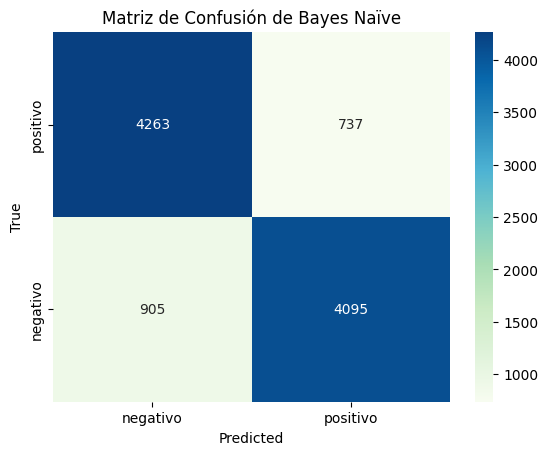

In [17]:
evaluar(y_test, y_pred_mnb,
        seed_splits=semilla,
        porcentaje_test=porcentaje_test,
        titulo_matriz="Matriz de Confusión de Bayes Naïve")

<hr width="30%" align="left" />

## **_Random Forest_**

Parámetros a tener en cuenta son:

* **criterion:** El criterio con el que decidir cómo dividir y qué nodos:
    - _"gini"_: Utiliza la impureza de Gini.
    - _"entropy"_: Utiliza el cálculo de entropía.

* **min_samples_leaf:** La cantidad mínima de muestras que una hoja debe tener para ser considerada tal.

* **min_samples_splits:** La cantidad mínima de muestras que un nodo debe tener como para considerar dividirlo.

* **n_estimators:** Cuántos árboles utilizar en la clasificación.

In [18]:
semilla_rf = 1

# # ----- Buscado por CV -----
# parametros_cv_rf = {
#       "criterion" : ["gini", "entropy"],
#       "min_samples_leaf" : np.arange(1, 50, 1),
#       "min_samples_split" : np.arange(2, 30, 1),
#       "n_estimators": np.arange(10, 450, 5),

# #     # para compatibilidad con la búsqueda manual
#      "max_features": ["sqrt", "log2"],
#      "oob_score": [True],
#      "random_state": [semilla_rf],
#      "n_jobs": [-1]
#   }

# cv_rf = buscar_por_cv(metodo="random",
#                         clasificador=RandomForestClassifier(),
#                         params_cv=parametros_cv_rf,
#                         puntaje="f1",
#                         rand_comb=5,
#                         folds=5,
#                         kfold_estratificado=True,
#                         seed=semilla)
# cv_rf.fit(X=x_train, y=y_train)

# print(f"{cv_rf.best_params_}\n"
#         f"{cv_rf.best_score_}")
# rfc = cv_rf.best_estimator_
# # --------------------------

# ----- Creado Manualmente -----
rfc = RandomForestClassifier(max_features="log2",
                             oob_score=True,
                             random_state=semilla_rf,
                             n_jobs=-1,
                             criterion="gini",
                             min_samples_leaf=2,
                             min_samples_split=12,
                             n_estimators=70)

rfc.fit(X=x_train,
        y=y_train_le)
# ------------------------------

RandomForestClassifier(max_features='log2', min_samples_leaf=2,
                       min_samples_split=12, n_estimators=70, n_jobs=-1,
                       oob_score=True, random_state=1)

In [19]:
y_pred_rf = le.inverse_transform(rfc.predict(x_test))

Splits Seed:	3
Model Seed:		1
Train/Test:		80.0% / 20.0%
-
Accuracy:		0.8406
Recall:			0.8516
Precision:		0.8332681017612524
f1 score:		0.8423343224530169


              precision    recall  f1-score   support

    negativo       0.85      0.83      0.84      5000
    positivo       0.83      0.85      0.84      5000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



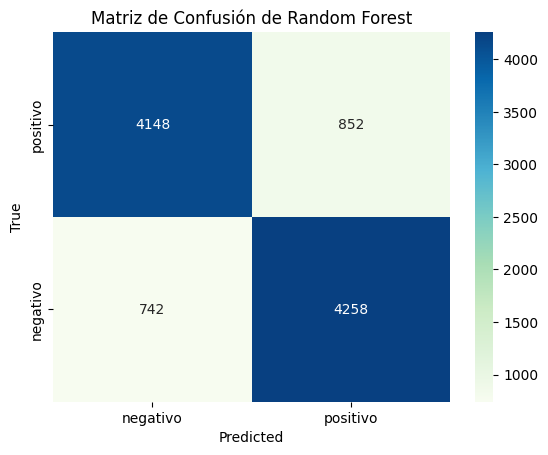

In [20]:
evaluar(y_test, y_pred_rf,
         seed_splits=semilla,
         seed_modelo=semilla_rf,
         porcentaje_test=porcentaje_test,
         titulo_matriz="Matriz de Confusión de Random Forest")

<hr width="30%" align="left" />

## _**eXtreme Gradient Boosting**_

Como siempre, los parámetros del _eXtreme Gradient Boosting_ (XGBoost) son bastantes. <br/>
Algunos optimizados son:

* **n_estimators:** Cuántos árboles utilizar en la clasificación.

* **max_depth:** Profundidad máxima que utilizar en cada árbol. _(A diferencia de por ejemplo el AdaBoost, acá los árboles pueden tener más profundidad)_

* **max_leaves:** Cantidad de hojas máxima por árbol.

* **learning_rate:** El coeficiente con el que ir suavizando los datos para no hacer _overfitting_.

In [21]:
semilla_xgb = 1

# # ----- Buscado por CV -----
# parametros_cv_xgb = {
#    "n_estimators": np.arange(50, 151),
#    "max_depth": np.arange(0, 20),
#    "max_leaves": np.arange(0, 30),
#    "gamma": np.linspace(0.0, 15, 50),
#    "reg_alpha": np.linspace(0.0, 5, 20),
#    "reg_lambda": np.linspace(0.0, 5, 20),
#    "learning_rate": np.linspace(0.0, 0.8, 50),
#   "n_jobs": [-1],
#    "random_state": [semilla_xgb]
# }
# cv_xgb = buscar_por_cv(metodo="random",
#                       clasificador=XGBClassifier(),
#                       params_cv=parametros_cv_xgb,
#                       puntaje="f1",
#                       rand_comb=50,
#                       folds=10,
#                       kfold_estratificado=True,
#                       seed=semilla)
# cv_xgb.fit(X=x_train, y=y_train_le)

# print(f"{cv_xgb.best_params_}\n"
#      f"{cv_xgb.best_score_}")
# xgb = cv_xgb.best_estimator_
# # --------------------------

# ----- Creado Manualmente -----
xgb = XGBClassifier(random_state=semilla_xgb,
                   n_jobs=-1,
                   n_estimators=100,
                   max_leaves=0,
                   max_depth=19,
                   learning_rate=0.2285714285714286,
                   reg_lambda=1.3157894736842104,
                   gamma=3.673469387755102,
                   reg_alpha=1.0526315789473684)

xgb.fit(x_train,
        y_train_le)
# ------------------------------

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=3.673469387755102, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2285714285714286,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=19, max_leaves=0,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, random_state=1, ...)

In [22]:
y_pred_xgb_enc = xgb.predict(x_test)
y_pred_xgb = le.inverse_transform(y_pred_xgb_enc)

Splits Seed:	3
Model Seed:		1
Train/Test:		80.0% / 20.0%
-
Accuracy:		0.8584
Recall:			0.8678
Precision:		0.8517864153906557
f1 score:		0.8597186447394493


              precision    recall  f1-score   support

    negativo       0.87      0.85      0.86      5000
    positivo       0.85      0.87      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



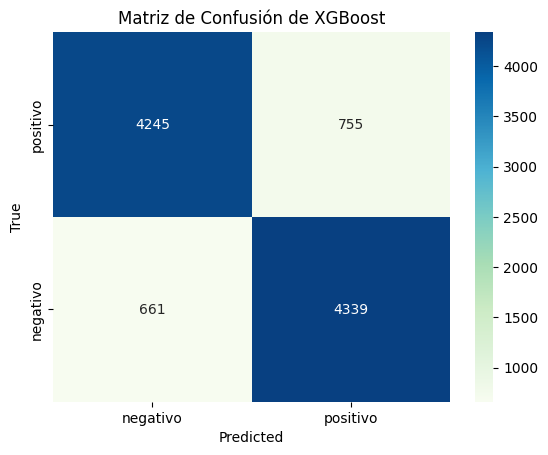

In [23]:
evaluar(y_test, y_pred_xgb,
        seed_splits=semilla,
        seed_modelo=semilla_xgb,
        porcentaje_test=porcentaje_test,
        titulo_matriz="Matriz de Confusión de XGBoost")

<hr width="30%" align="left" />

## **Redes Neuronales**

Primero, una función auxiliar para ayudar a compilar las redes:

In [24]:
def crear_red():
    """
    Crea y compila un red neuronal para ser usada más adelante.
    """

    d_in = len(x_train.columns)

    red = tf.keras.Sequential([
            tf.keras.layers.Dense(150, input_dim=d_in, activation="relu"),
            tf.keras.layers.Dense(15, activation="relu"),
            tf.keras.layers.Dense(1, activation="sigmoid")
        ]
    )

    red.compile(
        optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.001),
        loss="binary_crossentropy",
        metrics=["AUC"],
    )

    return red

Luego ya sí a entrenarlos:

In [25]:
# # ----- Buscado por CV -----
# parametros_cv_red = {
#     "epochs": np.arange(90, 170),
#     "batch_size": np.arange(10, 60),
#     "verbose": [False]
# }
# cv_red = buscar_por_cv(metodo="random",
#                        clasificador=KerasClassifier(model=crear_red),
#                        params_cv=parametros_cv_red,
#                        puntaje="f1",
#                        rand_comb=10,
#                        folds=10,
#                        kfold_estratificado=True,
#                        seed=semilla)
# cv_red.fit(X=x_train, y=y_train)

# print(f"{cv_red.best_params_}\n"
#       f"{cv_red.best_score_}")
# red = cv_red.best_estimator_
# # --------------------------

# ----- Creado Manualmente -----
red = crear_red()
red.summary()
red.fit(x_train_norm, y_train_le,
        epochs=300, batch_size=100, verbose=False)
# ------------------------------

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 150)               1852800   
                                                                 
 dense_1 (Dense)             (None, 15)                2265      
                                                                 
 dense_2 (Dense)             (None, 1)                 16        
                                                                 
Total params: 1,855,081
Trainable params: 1,855,081
Non-trainable params: 0
_________________________________________________________________


In [26]:
y_pred_red_sin_redondear = red.predict(x_test_norm)
y_pred_red = le.inverse_transform(np.round(y_pred_red_sin_redondear).astype(int))

313/313 [==============================] - 2s 7ms/step


Splits Seed:	3
Train/Test:		80.0% / 20.0%
-
Accuracy:		0.8689
Recall:			0.868
Precision:		0.8695652173913043
f1 score:		0.868781903713342


              precision    recall  f1-score   support

    negativo       0.87      0.87      0.87      5000
    positivo       0.87      0.87      0.87      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



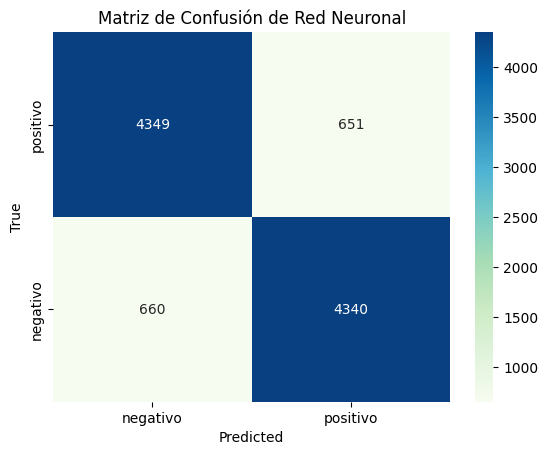

In [27]:
evaluar(y_test, y_pred_red,
        seed_splits=semilla,
        porcentaje_test=porcentaje_test,
        titulo_matriz="Matriz de Confusión de Red Neuronal")

<hr width="30%" align="left" />

## **Ensambles**

Como los modelos se entrenan de nuevo cuando se ensamblan, crearemos copias de los modelos ya entrenados para que no dependan entre sí. <br/>
Utilizaremos los modelos de _Random Forest_, _XGBoost_ y la red neuronal ya entrenadas, más unos ejemplos adicionales con otros parámetros.

In [ ]:
def crear_red_extra():
    """
    Crea y compila un red neuronal especialmente para los ensambles.
    """

    d_in = len(x_train.columns)

    red = tf.keras.Sequential([
            tf.keras.layers.Dense(130, input_dim=d_in, activation="relu"),
            tf.keras.layers.Dense(10, activation="relu"),
            tf.keras.layers.Dense(1, activation="sigmoid")
        ]
    )

    red.compile(
        optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.001),
        loss="binary_crossentropy",
        metrics=["AUC"],
    )

    return red

# ----- Creando Modelos -----
rf_1 = RandomForestClassifier(max_features="log2",
                             oob_score=True,
                             random_state=semilla_rf,
                             n_jobs=-1,
                             criterion="gini",
                             min_samples_leaf=2,
                             min_samples_split=12,
                             n_estimators=70)
xgb_1 = XGBClassifier(random_state=semilla_xgb,
                      n_jobs=-1,
                      n_estimators=100,
                      max_leaves=0,
                      max_depth=19,
                      learning_rate=0.2285714285714286,
                      reg_lambda=1.3157894736842104,
                      gamma=3.673469387755102,
                      reg_alpha=1.0526315789473684)
red_1 = KerasClassifier(model=crear_red, epochs=150, batch_size=100, verbose=0)
rf_2 = RandomForestClassifier(max_features="log2",
                              oob_score=True,
                              random_state=semilla_rf + 1,
                              n_jobs=-1,
                              criterion="gini",
                              min_samples_leaf=2,
                              min_samples_split=13,
                              n_estimators=115)
xgb_2 = xgb = XGBClassifier(random_state=semilla_xgb,
                            n_jobs=-1,
                            n_estimators=137,
                            max_leaves=0,
                            max_depth=20,
                            learning_rate=0.3285714285714286,
                            reg_lambda=1.5157894736842104,
                            gamma=2.173469387755102,
                            reg_alpha=0.9526315789473684)
red_2 = KerasClassifier(model=crear_red_extra, epochs=176, batch_size=117, verbose=0)
# ---------------------------

In [ ]:
modelos = [
    ("rf_1", rf_1),
    ("xgb_1", xgb_1),
    ("red_1", red_1),
    ("rf_2", rf_2),
    ("xgb_2", xgb_2),
    ("red_2", red_2)
]

<hr width="20%" align="left" />

### **Ensamble tipo _Voting_**

Este ensamble decide con los votos individuales de cada modelo. <br/>
Parámetros importantes son:

* **estimators:** Todos los clasificadores a utilizar.

* **voting:** La estrategia de voto:
    - _hard:_ Elige el valor dado por mayoría estricta.
    - _soft:_ Pondera con cálculos como el promedio, etc.

In [ ]:
voting = VotingClassifier(estimators=modelos,
                          voting="soft",
                          n_jobs=-1)
voting.fit(X=x_train_norm,
           y=y_train_le)

VotingClassifier(estimators=[('rf_1',
                              RandomForestClassifier(max_features='log2',
                                                     min_samples_leaf=2,
                                                     min_samples_split=12,
                                                     n_estimators=70, n_jobs=-1,
                                                     oob_score=True,
                                                     random_state=1)),
                             ('xgb_1',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=20,
                                            max_leaves=0, min_child_weight=None,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=137, n_jobs=-1,
                                            num_parallel_tree=None,
                                            random_state=1, ...)),
                             ('red_2',
                              KerasClassifier(batch_size=117, epochs=176, model=<function crear_red_extra at 0x7e323d2e9480>, verbose=0))],
                 n_jobs=-1, voting='soft')

In [ ]:
y_pred_voting_enc = voting.predict(x_test_norm)
y_pred_voting = le.inverse_transform(y_pred_voting_enc)

Splits Seed:	3
Train/Test:		80.0% / 20.0%
-
Accuracy:		0.8829
Recall:			0.8888
Precision:		0.8784344732160506
f1 score:		0.883586837657819


              precision    recall  f1-score   support

    negativo       0.89      0.88      0.88      5000
    positivo       0.88      0.89      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



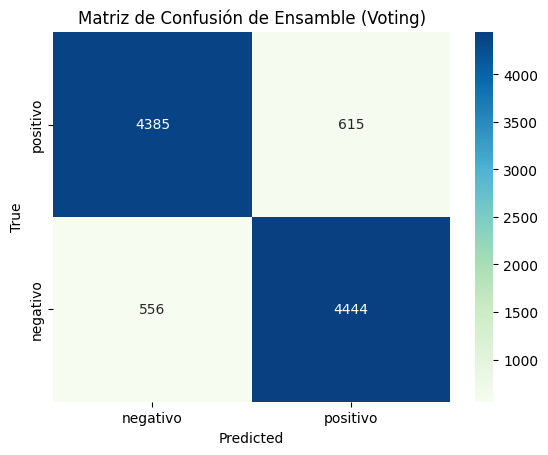

In [ ]:
evaluar(y_test, y_pred_voting,
        seed_splits=semilla,
        porcentaje_test=porcentaje_test,
        titulo_matriz="Matriz de Confusión de Ensamble (Voting)")

<hr width="20%" align="left" />

### **Ensamble tipo _Stacking_**

Este ensamble hace uso de un "meta-modelo" para decidir con qué modelo predecir. <br/>
Los parámetros son:

* **estimators:** Todos los clasificadores a utilizar.

* **final_estimator:** El "meta-modelo" que decide qué modelo de **estimators** utilizar.

* **passtrough:** Si el meta-modelo se entrena también con los datos de entrenamiento, y no sólo las predicciones hechas.

Creemos entonces primero el meta-modelo:

In [ ]:
meta_modelo = LogisticRegressionCV()

In [ ]:
stacking = StackingClassifier(estimators=modelos,
                              final_estimator=meta_modelo,
                              passthrough=True,
                              cv=KFold(n_splits=5),
                              n_jobs=-1,
                              verbose=2)
stacking.fit(X=x_train_norm,
             y=y_train_le)

StackingClassifier(cv=KFold(n_splits=5, random_state=RandomState(MT19937) at 0x7E32001CC740,
   shuffle=False),
                   estimators=[('rf_1',
                                RandomForestClassifier(max_features='log2',
                                                       min_samples_leaf=2,
                                                       min_samples_split=12,
                                                       n_estimators=70,
                                                       n_jobs=-1,
                                                       oob_score=True,
                                                       random_state=1)),
                               ('xgb_1',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=...
                                              max_leaves=0,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=137, n_jobs=-1,
                                              num_parallel_tree=None,
                                              random_state=1, ...)),
                               ('red_2',
                                KerasClassifier(batch_size=117, epochs=176, model=<function crear_red_extra at 0x7e323d2e9480>, verbose=0))],
                   final_estimator=LogisticRegressionCV(), n_jobs=-1,
                   passthrough=True, verbose=2)

In [ ]:
y_pred_stacking_enc = stacking.predict(x_test_norm)
y_pred_stacking = le.inverse_transform(y_pred_stacking_enc)

Splits Seed:	3
Train/Test:		80.0% / 20.0%
-
Accuracy:		0.8888
Recall:			0.8996
Precision:		0.8805794831636649
f1 score:		0.8899881282152751


              precision    recall  f1-score   support

    negativo       0.90      0.88      0.89      5000
    positivo       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



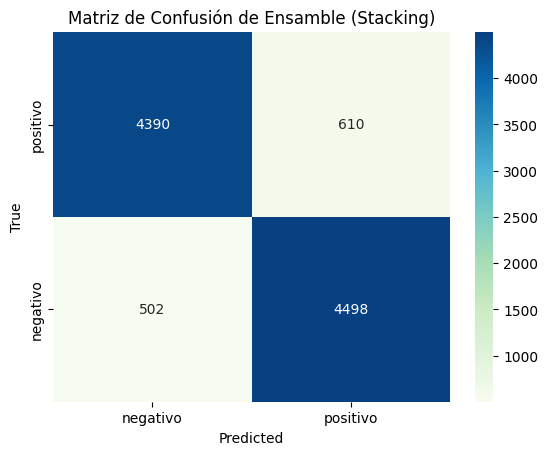

In [ ]:
evaluar(y_test, y_pred_stacking,
        seed_splits=semilla,
        porcentaje_test=porcentaje_test,
        titulo_matriz="Matriz de Confusión de Ensamble (Stacking)")

<hr/>

# **Exportando Predicciones**

In [ ]:
def generar_predicciones(df_test: pd.DataFrame,
                         *,
                         modelo,
                         vectorizador: Union[CountVectorizer, TfidfVectorizer, None]=None,
                         normalizar_splits: bool=False,
                         escalador: Literal["std", "minmax"]="std",
                         encodeador: Optional[LabelEncoder]=None,
                         redondear: bool=False) -> np.ndarray:
    """
    Toma un  dataset de testeo, y genera las predicciones para ese modelo.
    -
    'df_test': El dataset de testeo.

    'modelo': El modelo de predicción, ya entrenado.

    'vectorizador': El objeto que vectoriza las palabras del dataset de testeo.

    'normalizar_splits': Los splits, donde sea posible, serán normalizados con un escalador.

    'escalador': El escalador con el que normalizar los splits:
                 - 'std' utiliza `sklearn.preprocessing.StandardScaler`.
                 - 'minmax' utiliza `sklearn.preprocessing.MinMaxScaler`.

    'redondear': Normalmente utilizada con redes neuronales, este parámetro indica si se
                 deben redondear los valores al entero más cercano, y castearlos a `int`s.

    'encodeador': Si el output fue encodeado (por ejemplo con `sklearn.LabelEncoder()`),
                  desencodear los resultado mediante `encoder.inverse_transform()`.
                  Dicho encodeador ya debe haber fitteado al menos una vez.
                  Como esto tiene en cuenta enteros, es preferible que si se trabaja con floats
                  se especifique `redondear=True`.
    """

    if escalador not in ("std", "minmax"):
        raise ValueError(f"Argumento escalador='{escalador}' no válido. Debe ser 'std' o 'minmax'.")

    test_vect = vectorizar_palabras(df_test, vectorizador=vectorizador)
    test_x, _ = split_in_axes(test_vect)

    if normalizar_splits:
        if escalador == "std":
            scaler = StandardScaler(with_mean=False)
        elif escalador == "minmax":
            scaler = MinMaxScaler()

        x_a_predecir = scaler.fit_transform(test_x)

    else:
        x_a_predecir = test_x

    predicciones = modelo.predict(x_a_predecir)

    if redondear:
        predicciones = np.round(predicciones).astype(int)

    if encodeador is not None:
        predicciones = encodeador.inverse_transform(predicciones)

    return predicciones

In [ ]:
def exportar_predicciones(df_test: pd.DataFrame, predicciones: np.ndarray,
                          *,
                          target: str="sentimiento",
                          nombre: "PathLike", # Más bien que se parezca a un nombre de archivo con extensión
                          ruta: "PathLike"="./drive/MyDrive/Colab Notebooks/predictions") -> None:
    """
    Intenta guardar las predicciones en una ruta en Google Drive, para uso interno. Normalmente
    como forma temporal para después subirlo a kaggle.
    Se presupone que el drive ya fue montado junto con los imports.
    -
    'df_test': El DataFrame de los datos a predecir. De acá sacamos la columna 'id'.

    'predicciones': Un `numpy.ndarray` (o lo que salga de `model.predict()`). Estos son los valores
                    que han de llenar la columna del target.

    'target': El nombre de la columna del target. A efectos de este TP2 siempre debería
              ser `"sentimiento"`.

    'nombre': El nombre del archivo en cuestión, de formato `.csv`. Ejemplo: `"predicted1.csv"`.

    'ruta': Ruta del directorio en Drive donde el archivo será guardado.
    """

    path = Path(ruta) / nombre
    df_a_exportar = pd.DataFrame()

    df_a_exportar.insert(loc=0, column="ID", value=df_test["ID"])
    df_a_exportar.insert(loc=1, column=target, value=predicciones)

    df_a_exportar.to_csv(path, index=False)

In [ ]:
# predicciones = generar_predicciones(test, vectorizador=vect, modelo=stacking,
#                                     normalizar_splits=True,
#                                     encodeador=le, redondear=False)
# exportar_predicciones(test, predicciones,
#                       nombre="predicciones_ensamble_stacking.csv")